In [211]:
import numpy as np
import scipy as sc
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad
from matplotlib import colors
from EBL_fit_MC_functions import *
from scipy.stats import norm
from scipy.stats import poisson
import yaml
import matplotlib.pyplot as plt
import h5py
import time
import sys
import os
import uproot
from scipy.stats import norm, chi2
from pathlib import Path

In [212]:
Source_name = "Mrk421_20130415c" #'PG1553_ST0203' "1ES1011_Feb2014", 'Mrk421_20130415c',
Source_z = 0.03
if Source_name == "Mrk421_20130415c":
    data_path = "/home/rgrau/Desktop/EBL_analysis_Feb2018/Mrk421_20130415c/light+00/Output_flute.root"#"/home/rgrau/Desktop/EBL_Gamma2016/EBL_samples/{0}/data/nominal/flute/Output_flute.root".format(Source_name)#"/home/rgrau/Desktop/EBL_Gamma2016/EBL_samples/Mrk421_20130415c/data/nominal/flute/Output_flute.root"
else:
    data_path = "/home/rgrau/Desktop/EBL_analysis_Feb2018/{0}/data/nominal/flute/Output_flute.root".format(Source_name)
knots = 4
Emin = 0.06
Emax = 15.
break_lim_0 = 0.1
break_limit = 4.
sum_lim = 1.

fit_func_name = "MBPWL"
Telescope = "MAGIC"
EBL_Model = "Dominguez"
# Source_flux = inp_config["Source_flux"]
Observation_time = 42480
Background_scale = 1.
Forward_folding = True
Norm = 0.25
# Ph_index = inp_config["Ph_index"]
if knots == 1:
    initial_guess_0 = np.array((5e-6, 2.0, 0.0, 2.))
else:
    initial_guess_0 = np.zeros(knots + 4)
    initial_guess_0[0] = 5e-6
    initial_guess_0[1] = 2.0
    initial_guess_0[-1] = 0.1
    initial_guess_0[-2] = 0.1
# LP_curvature = inp_config["LP_curvature"]

def fit_func(xdata, params): #for 1 knot
    if knots == 1:
        polw = np.zeros(len(xdata))
        gamma = np.zeros(knots+1)
        phi = np.zeros(knots+1)
        phi_0 = params[0] #len(sqrtdelta_lam) = len(lam)-1 = len(phi)-1
        gamma0 = params[1]
        sqrtdelta_gamma = params[2:knots+2]
        Eknot = params[-1]
        delta_gamma = np.square(sqrtdelta_gamma)
        gamma[0] = gamma0
        phi[0] = phi_0
        gamma[1] = gamma[0] + delta_gamma[0]
        phi[1] = phi[0] * (Eknot/0.25) ** delta_gamma[0]
        for i in range(len(xdata)):
            if xdata[i] < Eknot:
                polw[i] = phi[0] * (xdata[i]/0.25) ** (-gamma[0])
            elif xdata[i] >= Eknot:
                polw[i] = phi[1] * (xdata[i]/0.25) ** (-gamma[1])
        return polw
    else:
        polw = np.zeros(len(xdata))

        gamma = np.zeros(knots+1)
        phi = np.zeros(knots+1)
        phi_0 = params[0] #len(sqrtdelta_lam) = len(lam)-1 = len(phi)-1
        gamma0 = params[1]
        sqrtdelta_gamma = params[2:knots+2]
        Efirst = params[-2]
        DeltaElast = params[-1]
        Elast = Efirst + DeltaElast
        Ebr = np.geomspace(Efirst, Elast, knots)
        delta_gamma = np.square(sqrtdelta_gamma)
        gamma[0] = gamma0
        phi[0] = phi_0
        for i in range(knots):
            gamma[i+1] = gamma[i] + delta_gamma[i]
            phi[i+1] = phi[i] * (Ebr[i]/0.25) ** delta_gamma[i]
        for i in range(len(xdata)):
            for j in range(knots):
                if xdata[i]<Ebr[0]:
                    polw[i] = phi[0] * (xdata[i]/0.25) ** (-gamma[0])
                elif Ebr[-1] < xdata[i]:
                    polw[i] = phi[-1] * (xdata[i]/0.25) ** (-gamma[-1])
                elif Ebr[j] <= xdata[i] < Ebr[j+1]:
                    polw[i] = phi[j+1] * (xdata[i]/0.25) ** (-gamma[j+1])
        return polw

if Telescope == "CTAN_alpha": #this part needs to be changed to include the real CTAN_alpha configuration
    Noffregions = 5
    def m2LogL(params):
        xdata = E_EBL
        mtau = -tau
        mu_gam0 = dNdE_to_mu((fit_func(xdata, params) * np.exp(mtau * alpha))[2:37], Effa_reb, Ebinsw[2:37], Observation_time, Ebins, Eres_reb2, E_EBL[2:37])
        mu_gam = mu_gam0[5:-4]
        mu_bg = mu_BG(mu_gam, Non, Noff, Noffregions)
        min_num_gauss = 20
        conditions = [((Non >= min_num_gauss) & (Noff >= min_num_gauss)), (Non == 0.), (Noff == 0.), (Non != 0.) & (Noff != 0.)]
        choices = [Gauss_logL(Non, Noff, mu_gam, Noffregions), Poisson_logL_Non0(Non, Noff, mu_gam, Noffregions), Poisson_logL_Noff0(Non, Noff, mu_gam, Noffregions), Poisson_logL(Non, Noff, mu_gam, mu_bg, Noffregions)]
        res = np.select(conditions, choices, default = 999999999)
        return np.sum(res)
        
elif Telescope == "MAGIC":
    Noffregions = 3
    def m2LogL(params):
        xdata = Etrue
        mtau = -tau
        mu_gam = dNdE_to_mu_MAGIC(fit_func(xdata, params), Ebinsw_Etrue, migmatval, Eest)
        mu_gam_final = mu_gam[minbin:maxbin]
        Non_final = Non[minbin:maxbin] 
        Noff_final = Noff[minbin:maxbin]
        mu_bg = mu_BG(mu_gam, Non, Noff, Noffregions)
        mu_bg_final = mu_bg[minbin:maxbin]
        min_num_gauss = 20
        conditions = [((Non_final >= min_num_gauss) & (Noff_final >= min_num_gauss)), (Non_final == 0.), (Noff_final == 0.), (Non_final != 0.) & (Noff_final != 0.)]
        choices = [Gauss_logL(Non_final, Noff_final, mu_gam_final, Noffregions), Poisson_logL_Non0(Non_final, Noff_final, mu_gam_final, Noffregions), Poisson_logL_Noff0(Non_final, Noff_final, mu_gam_final, Noffregions), Poisson_logL(Non_final, Noff_final, mu_gam_final, mu_bg_final, Noffregions)]
        res = np.select(conditions, choices, default = 999999999)
        return np.sum(res)

def fit(initial_guess):
    
    m2LogL.errordef = Minuit.LIKELIHOOD
    m = Minuit(m2LogL, initial_guess)
    MBPWL_limits = ([(1e-6, 1e-3), (-4., 5.)])
    for i in range(knots):
        MBPWL_limits.append(None)
    if knots == 1:
        MBPWL_limits.append((0.08, 4.0))
    else:
        MBPWL_limits.append((break_lim_0, break_limit)) #0.13 for 3 knots 0.1 for 4 knots
        MBPWL_limits.append((sum_lim, None))
    m.limits = MBPWL_limits
    #m.tol = 1e-6
    #m.strategy = 2

    m.migrad()
    return m
# if EBL_Model == "Dominguez": #loads the EBL data of the Dominguez et al 2011 paper.
#     possible_z = np.array([0.01, 0.02526316, 0.04052632, 0.05578947, 0.07105263, 0.08631579, 0.10157895, 0.11684211, 0.13210526, 0.14736842, 0.16263158, 0.17789474, 0.19315789, 0.20842105, 0.22368421, 0.23894737, 0.25421053, 0.26947368, 0.28473684, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75])
#     closest_z = find_z(possible_z, Source_z)
#     file = np.loadtxt('/home/rgrau/Desktop/EBL-splines/tau_dominguez11.out')
#     pdfile = pd.DataFrame(file)
#     pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105', 15: 'tau z=0.22368421', 16: 'tau z=0.23894737', 17: 'tau z=0.25421053', 18: 'tau z=0.26947368', 19: 'tau z=0.28473684', 20: 'tau z=0.3' , 21: 'tau z=0.35', 22: 'tau z=0.4' , 23: 'tau z=0.45', 24: 'tau z=0.5', 25: 'tau z=0.55', 26: 'tau z=0.6', 27: 'tau z=0.65', 28: 'tau z=0.7' , 29: 'tau z=0.75'})
#     E_EBL = pdfile['E [TeV]'].to_numpy() #energy bins
#     tau_EBL = pdfile['tau z={0}'.format(closest_z)].to_numpy() #tau bins
# else:
#     raise Exception('The EBL model "{func}" has not been implemented.'.format(func = EBL_Model))

In [213]:
if Telescope == "MAGIC": #compute values needed for minimization if the selected telescope is MAGIC
    
    Bckg = uproot.open("{0}:hEstBckgE".format(data_path))#uproot.open(data_path + ":hEstBckgE")#load background values
    bckgmu_final = Bckg.values() #counts in 42480s (can be normalized for any time but as the migmatrix is for that time, only use that time).

    migrmatrix = uproot.open("/home/rgrau/Desktop/EBL-splines/fold_migmatrix_{0}.root:mig_matrix".format(Source_name))
    migmatval = migrmatrix.values() #m^2 * s #values
    migmatxEtrue = migrmatrix.axis("x").edges()/1e3 #TeV #edge values of X axis of the migration matrix (True Energy)
    migmatyEest = migrmatrix.axis("y").edges()/1e3 #TeV #edge values of Y axis of the migration matrix (Estimated Energy)

    Eest = migrmatrix.axis("y").centers()/1e3 #TeV #center values of X axis of the migration matrix (True Energy)
    Etrue = migrmatrix.axis("x").centers()/1e3 #TeV #center values of Y axis of the migration matrix (Estimated Energy)
    E_final = Etrue
    Usedbins = np.where((Emin <= Eest) & (Eest <= Emax))
    minbin = Usedbins[0][0]
    maxbin = Usedbins[0][-1] + 1
    Eest_final = Eest[minbin:maxbin]
    
    tau = tau_interp(Etrue, Source_z, EBL_Model, kind_of_interp = "log") #interpolate the tau values to have the same bins as the migration matrix and the data.
    Ebinsw_final = migmatyEest[1:] - migmatyEest[:-1] #compute the bin width of the final energy bins
    Ebinsw_Etrue = migmatxEtrue[1:] - migmatxEtrue[:-1] #compute the bin width of Etrue energy bins

    excess = uproot.open("/home/rgrau/Desktop/EBL-splines/excess_{0}.root:_px".format(Source_name))
    excess_events = excess.values() #Energy bins = Eest

    mu_vec_final = excess_events

In [214]:
def process2(mu_on, mu_off):
    global Non, Noff
    Non, Noff = np.round(mu_on), np.round(Noffregions * mu_off)
    Non_u, Noff_u = np.sqrt(Non), np.sqrt(Noff)
    things = fit(initial_guess=initial_guess_0)
    if things.valid == False:
        raise Warning("The minimum is not valid")
    chi2 = m2LogL(things.values)
    return chi2, things.values

mu_on = mu_vec_final + bckgmu_final
mu_off = bckgmu_final 
chis, fit_results = process2(mu_on, mu_off)
print(fit_results, chis)

/home/rgrau/Desktop/EBL-splines/EBL_fit_MC_functions.py:278: RuntimeWarning: divide by zero encountered in log
  logL = np.log(poisson.pmf(Non, mu_gam + mu_bg)) + np.log(poisson.pmf(Noff, Nwobbles * mu_bg)) #change this to sum of logs.(and maybie add gaussian)


<ValueView x0=5.04660731918024e-05 x1=1.816223696374213 x2=-0.5969562353745598 x3=-0.3470229595435779 x4=-0.8490674586125633 x5=-2.061646870982995 x6=0.3793909650883795 x7=9.428064210079377> 6.274168389226822


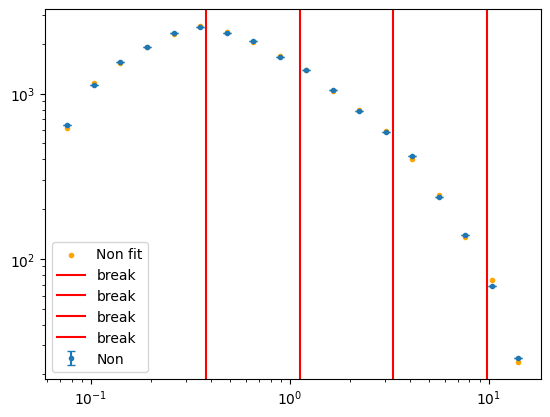

In [215]:
E_forplot = Eest[minbin:maxbin]
mu_gam = dNdE_to_mu_MAGIC((fit_func(E_final, fit_results)), Ebinsw_Etrue, migmatval, Eest)
mu_gam_final = mu_gam[minbin:maxbin]
mu_bg = mu_BG(mu_gam, Non, Noff, Noffregions)
mu_bg_final = mu_bg[minbin:maxbin]
mu_on_sim = mu_gam_final + mu_bg_final
if knots == 1:
    Ebreaks = fit_results[-1]
else:
    Ebreaks = np.geomspace(fit_results[knots + 2], fit_results[knots + 2] + fit_results[knots + 3], knots)

plt.errorbar(E_forplot, Non[minbin:maxbin], yerr=0, fmt = ".", label = "Non", capsize = 3)
plt.scatter(E_forplot, mu_on_sim, marker = ".", label = "Non fit", color = 'orange')
# plt.axvline(fit_results[3])
if knots == 1:
    plt.axvline(Ebreaks, label = "break", color = "red")
else:
    for i in range(knots):
        plt.axvline(Ebreaks[i], label = "break", color = "red")
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

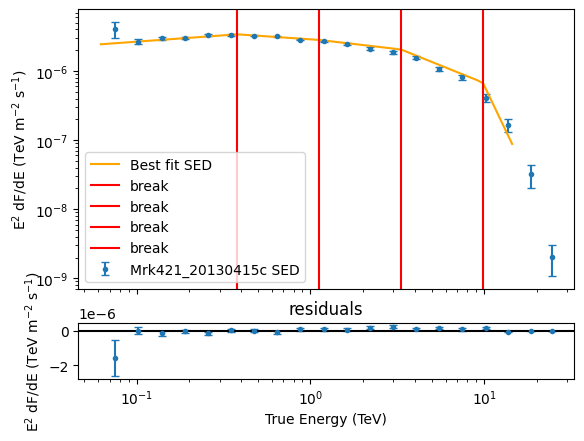

In [216]:
Data = uproot.open(data_path + ":DiffEspectrum")
Data_values = Data.values()
dNdE_u = Data.errors("mean")[1]
dNdE = Data_values[1] # 1/ cm^2 / s / TeV
Eest_data = Data_values[0] * 1e-3 #TeV
SED_orig = Eest_data * Eest_data * dNdE * 1e4 #put it in 1/m^2 instead of 1/cm^2
SED_orig_u = Eest_data *  Eest_data * dNdE_u *1e4
SED_fit = fit_func(Etrue, fit_results) * Etrue * Etrue
SED_fit2 = fit_func(Eest_data, fit_results) * Eest_data * Eest_data
binw = np.zeros(len(Eest)-1)

Etrue_bins = np.where((Emin <= Etrue) & (Etrue <= Emax))
minbin_tr = Etrue_bins[0][0]
maxbin_tr = Etrue_bins[0][-1] + 1


f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]}, sharex=True)
ax1.errorbar(Eest_data, SED_orig, yerr= SED_orig_u, fmt = ".", capsize = 3, label = "{0} SED".format(Source_name))
# ax1.errorbar(Eest_final, SED_orig, yerr=SED_orig_u, fmt = ".", label = "Assimov dataset SED")
ax1.plot(Etrue[minbin_tr:maxbin_tr], SED_fit[minbin_tr:maxbin_tr], label = "Best fit SED", color = 'orange')
if knots == 1:
    ax1.axvline(Ebreaks, label = "break", color = "red")
else:
    for i in range(knots):
        ax1.axvline(Ebreaks[i], label = "break", color = "red")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlabel("True Energy (TeV)")
ax1.set_ylabel(r"E$^2$ dF/dE (TeV m$^{-2}$ s$^{-1}$)")
ax1.legend()
ax2.errorbar(Eest_data, SED_fit2 - SED_orig, yerr= SED_orig_u, fmt = ".", capsize = 3)
ax2.axhline(color = "black")
ax2.set_title("residuals")
ax2.set_ylabel(r"E$^2$ dF/dE (TeV m$^{-2}$ s$^{-1}$)")
# ax2.set_yscale('log')
plt.show()

In [217]:
print(Ebreaks)

[0.37939097 1.12178622 3.3169064  9.80745518]


In [218]:
SED_orig_u

array([1.06836940e-06, 2.10728560e-07, 1.33748572e-07, 1.05801971e-07,
       9.48437733e-08, 8.56003405e-08, 8.26588108e-08, 8.25693508e-08,
       8.09729602e-08, 8.16894344e-08, 8.43209737e-08, 8.33927191e-08,
       8.46651532e-08, 8.28712255e-08, 7.43145381e-08, 7.34373822e-08,
       5.23371161e-08, 3.64944043e-08, 1.18928867e-08, 9.69994650e-10])